# Very simple CNN for MNIST classification


Implement the network in the diagram below for MNIST classification. 

- Imports, including `torch` and `Rearrange` from `einops.layers.torch`.
- Datasets and dataloaders.
- Define the CNN. The convolution layers both have kernel size 3 and stride 1, with zero padding. The max pooling has a kernel size of 2. I use `nn.Sequential()` and `Rearrange` from einops.layers.torch instead of a model class inheriting from `nn.Module`.
- Function to train model for single epoch.
- Function to evaluate model on test data.
- Train model. 

There's no hyperparameter optimization or experimentation with architecture. 

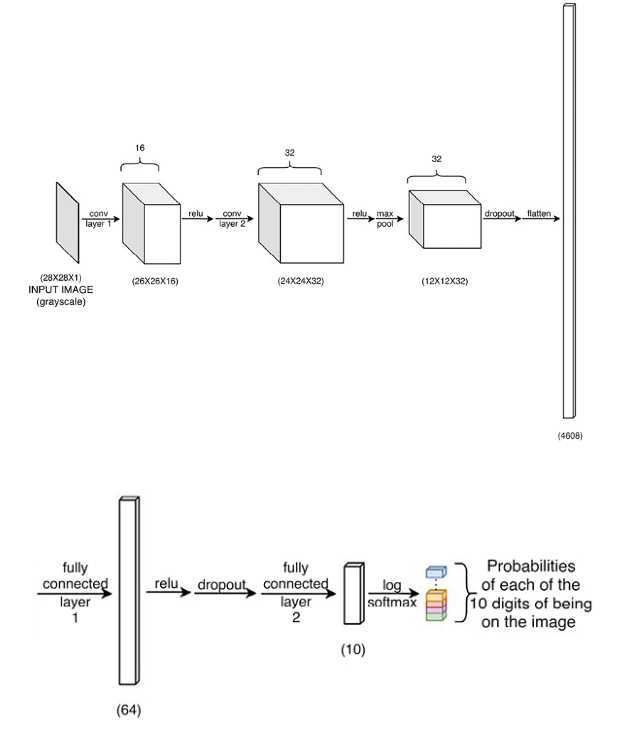

In [45]:
from IPython.display import Image
Image('images/cnn-mnist.png')

### Imports

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from einops.layers.torch import Rearrange

### Datasets and dataloaders

In [47]:
untransformed_train_dataset = datasets.MNIST('/data', train=True,
    download=True, transform=transforms.ToTensor())

In [48]:
DATA_MEAN = untransformed_train_dataset.data.float().mean() / 255
DATA_STD = untransformed_train_dataset.data.float().std() / 255

DATA_MEAN, DATA_STD

(tensor(0.1307), tensor(0.3081))

In [49]:
len(untransformed_train_dataset)

60000

In [50]:
train_dataset = datasets.MNIST('/data', train=True, download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

test_dataset = datasets.MNIST('/data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=500, shuffle=False)

### Network

In [51]:
conv_net = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout2d(0.10),
    Rearrange('b c h w -> b (c h w)'),
    nn.Linear(32 * 12 * 12, 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(128, 10)
)

In [52]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3, 1)
#         self.conv2 = nn.Conv2d(16, 32, 3, 1)
#         self.relu = nn.ReLU()
#         self.max_pool2d = nn.MaxPool2d(2)
#         self.dropout2d = nn.Dropout2d(0.10)
#         self.dropout = nn.Dropout(0.25)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(4608, 64) # 4608 = 32*12*12
#         self.fc2 =  nn.Linear(64, 10)

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))
#         x = self.max_pool2d(x)
#         x = self.dropout2d(x)
#         x = self.flatten(x)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

### Define model, device, optimizer, and loss function, and set seed

In [53]:
torch.manual_seed(0)
#model = ConvNet()
model = conv_net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [54]:
print(model)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout2d(p=0.1, inplace=False)
  (6): Rearrange('b c h w -> b (c h w)')
  (7): Linear(in_features=4608, out_features=128, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.25, inplace=False)
  (10): Linear(in_features=128, out_features=10, bias=True)
)


In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 596,042 trainable parameters


### Function to train model for one epoch

In [56]:
def train(model, device, train_dataloader, optimizer, 
        loss_function, epoch):
    model.train()
    train_loss = 0.
    correct = 0
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        prediction_logits = model(images)
        loss = loss_function(prediction_logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predictions = prediction_logits.argmax(dim=1)
        batch_correct = predictions.eq(labels).sum().item()
        correct += batch_correct
        if (batch_idx + 1) % 100 == 0:
            print(f'{(100*batch_idx+1)/(len(train_dataloader)):.2f}% of epoch {epoch+1}')
    print(f'Train acc.: {100 * correct / len(train_dataset):.2f} %')   

### Function to evaluate model on test data

In [57]:
def test(model, device, test_dataloader, loss_function):
    model.eval()
    test_loss = 0.
    correct = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction_logits = model(images)
            test_loss += loss_function(prediction_logits, labels).item()
            predictions = prediction_logits.argmax(dim=1)
            correct += predictions.eq(labels).sum().item()
    print(f'Test acc.: {100 * correct/len(test_dataset):.2f} %')

### Train model

In [58]:
for epoch in range(2):
    train(model, device, train_dataloader, optimizer, loss_fn, epoch)
    test(model, device, test_dataloader, loss_fn)   

5.28% of epoch 1
10.61% of epoch 1
15.95% of epoch 1
21.28% of epoch 1
26.61% of epoch 1
31.95% of epoch 1
37.28% of epoch 1
42.61% of epoch 1
47.95% of epoch 1
53.28% of epoch 1
58.61% of epoch 1
63.95% of epoch 1
69.28% of epoch 1
74.61% of epoch 1
79.95% of epoch 1
85.28% of epoch 1
90.61% of epoch 1
95.95% of epoch 1
Train acc.: 95.31 %


NameError: name 'prediction_probs' is not defined